In [ ]:
'''
 * Copyright (c) 2008 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Variational Bayesian Linear Regression

In this notebook, we derive the variational Bayesian solution to the Bayesian linear regression model. The aim is to approximate the posterior $ p(w, \alpha \mid t) $ using variational inference.

## Model Setup

The likelihood function for the weights $w$ and the prior over $w$ are given by:

$$
p(t \mid w) = \prod_{n=1}^N \mathcal{N}(t_n \mid w^\top \phi_n, \beta^{-1})
$$

$$
p(w \mid \alpha) = \mathcal{N}(w \mid 0, \alpha^{-1} I)
$$

where $\phi_n = \phi(x_n)$.

We introduce a prior over $\alpha$:

$$
p(\alpha) = \text{Gam}(\alpha \mid a_0, b_0)
$$

Thus, the joint distribution is:

$$
p(t, w, \alpha) = p(t \mid w) p(w \mid \alpha) p(\alpha)
$$

## Variational Approximation

We aim to approximate the posterior $ p(w, \alpha \mid t) $ with a factorized variational posterior:

$$
q(w, \alpha) = q(w)q(\alpha)
$$

### Update for $q(\alpha)$

From the joint distribution:

$$
\ln q^*(\alpha) = \ln p(\alpha) + \mathbb{E}_w[\ln p(w \mid \alpha)] + \text{const}
$$

Expanding the terms:

$$
\ln q^*(\alpha) = \left(a_0 - 1\right) \ln \alpha - b_0 \alpha + \frac{M}{2} \ln \alpha - \frac{\mathbb{E}[w^\top w]}{2} \alpha + \text{const}
$$

Recognizing this as the log of a Gamma distribution:

$$
q(\alpha) = \text{Gam}(\alpha \mid a_N, b_N)
$$

where:

$$
a_N = a_0 + \frac{M}{2}, \quad b_N = b_0 + \frac{\mathbb{E}[w^\top w]}{2}
$$

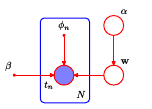

Fig.8 Probabilistic graphical model representing the joint distribution (10.90) for the Bayesian linear regression model.

### Update for $q(w)$

From the joint distribution:

$$
\ln q^*(w) = \ln p(t \mid w) + \mathbb{E}_\alpha[\ln p(w \mid \alpha)] + \text{const}
$$

Expanding the terms:

$$
\ln q^*(w) = -\frac{\beta}{2} \sum_{n=1}^N (w^\top \phi_n - t_n)^2 - \frac{\mathbb{E}[\alpha]}{2} w^\top w + \text{const}
$$

Simplifying to a quadratic form:

$$
\ln q^*(w) = -\frac{1}{2} w^\top \left(\mathbb{E}[\alpha] I + \beta \Phi^\top \Phi\right) w + \beta w^\top \Phi^\top t + \text{const}
$$

Thus, $q(w)$ is Gaussian:

$$
q(w) = \mathcal{N}(w \mid m_N, S_N)
$$

where:

$$
m_N = \beta S_N \Phi^\top t, \quad S_N = \left(\mathbb{E}[\alpha] I + \beta \Phi^\top \Phi\right)^{-1}
$$

### Expectations

To compute the expectations, we use the following results:

$$
\mathbb{E}[\alpha] = \frac{a_N}{b_N}
$$

$$
\mathbb{E}[w^\top w] = m_N^\top m_N + \text{Tr}(S_N)
$$

### Variational Algorithm

1. **Initialize**:
    - Set initial values for $q(w)$ or $q(\alpha)$.

2. **Iterate**:
    - Update $q(w)$ based on the current expectation $\mathbb{E}[\alpha]$.
    - Update $q(\alpha)$ based on the current expectation $\mathbb{E}[w^\top w]$.

3. **Convergence**:
    - Check for convergence using a criterion such as the change in the lower bound.

---

## Summary

The variational approach for Bayesian linear regression provides an approximate posterior distribution over $w$ and $\alpha$, where the posterior $q(w)$ is Gaussian and $q(\alpha)$ is Gamma. The method alternates between updating these factors until convergence.


In [1]:
import numpy as np

class VariationalBayesianLinearRegression:
    def __init__(self, a0=1e-6, b0=1e-6, beta=1.0):
        """
        Initialize the model with prior hyperparameters.
        :param a0: Prior shape parameter for Gamma distribution of alpha.
        :param b0: Prior rate parameter for Gamma distribution of alpha.
        :param beta: Known noise precision (1 / variance of observation noise).
        """
        self.a0 = a0
        self.b0 = b0
        self.beta = beta
        self.aN = None
        self.bN = None
        self.mN = None
        self.SN = None

    def fit(self, X, t, max_iter=100, tol=1e-6):
        """
        Fit the model to the data using variational inference.
        :param X: Input design matrix of shape (N, M).
        :param t: Target values of shape (N,).
        :param max_iter: Maximum number of iterations for the variational updates.
        :param tol: Convergence tolerance for the lower bound.
        """
        N, M = X.shape
        Phi = X
        self.aN = self.a0 + M / 2.0
        self.bN = self.b0
        self.mN = np.zeros(M)
        self.SN = np.eye(M)

        for i in range(max_iter):
            # Compute E[alpha]
            E_alpha = self.aN / self.bN

            # Update posterior over weights q(w)
            SN_inv = E_alpha * np.eye(M) + self.beta * Phi.T @ Phi
            self.SN = np.linalg.inv(SN_inv)
            self.mN = self.beta * self.SN @ Phi.T @ t

            # Update posterior over alpha q(alpha)
            E_wt_w = self.mN.T @ self.mN + np.trace(self.SN)
            self.bN = self.b0 + 0.5 * E_wt_w

            # Convergence check (optional, based on change in parameters)
            if i > 0 and np.abs(prev_bN - self.bN) < tol:
                break
            prev_bN = self.bN

    def predict(self, X_new):
        """
        Predict the mean and variance for new data points.
        :param X_new: New design matrix of shape (N_new, M).
        :return: Tuple (mean, variance) of the predictive distribution.
        """
        mean = X_new @ self.mN
        variance = 1 / self.beta + np.sum(X_new @ self.SN * X_new, axis=1)
        return mean, variance


# Example usage
if __name__ == "__main__":
    # Generate synthetic data
    np.random.seed(42)
    N = 50
    M = 2
    X = np.random.randn(N, M)
    true_w = np.array([2.0, -1.0])
    t = X @ true_w + np.random.normal(0, 0.5, size=N)

    # Fit the model
    vb_reg = VariationalBayesianLinearRegression(a0=1e-3, b0=1e-3, beta=2.0)
    vb_reg.fit(X, t)

    # Predict on new data
    X_new = np.random.randn(5, M)
    mean, variance = vb_reg.predict(X_new)

    print("Predictive Mean:\n", mean)
    print("Predictive Variance:\n", variance)


Predictive Mean:
 [ 0.13075574 -1.54968613  1.29362328  3.11999863 -2.96917376]
Predictive Variance:
 [0.50203826 0.50734331 0.50682969 0.55073809 0.52569462]


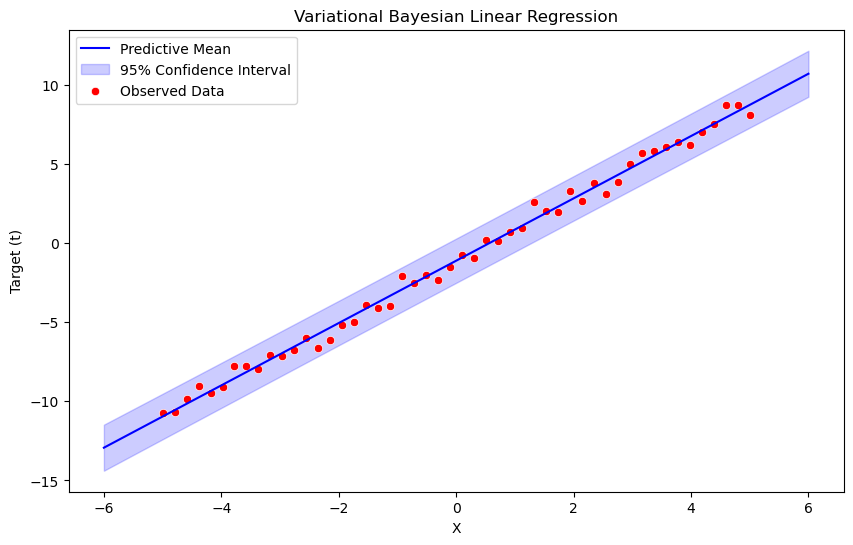

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

class VariationalBayesianLinearRegression:
    def __init__(self, a0=1e-6, b0=1e-6, beta=1.0):
        self.a0 = a0
        self.b0 = b0
        self.beta = beta
        self.aN = None
        self.bN = None
        self.mN = None
        self.SN = None

    def fit(self, X, t, max_iter=100, tol=1e-6):
        N, M = X.shape
        self.aN = self.a0 + M / 2.0
        self.bN = self.b0
        self.mN = np.zeros(M)
        self.SN = np.eye(M)

        for i in range(max_iter):
            # Compute E[alpha]
            E_alpha = self.aN / self.bN

            # Update posterior over weights q(w)
            SN_inv = E_alpha * np.eye(M) + self.beta * X.T @ X
            self.SN = np.linalg.inv(SN_inv)
            self.mN = self.beta * self.SN @ X.T @ t

            # Update posterior over alpha q(alpha)
            E_wt_w = self.mN.T @ self.mN + np.trace(self.SN)
            self.bN = self.b0 + 0.5 * E_wt_w

            # Convergence check
            if i > 0 and np.abs(prev_bN - self.bN) < tol:
                break
            prev_bN = self.bN

    def predict(self, X_new):
        mean = X_new @ self.mN
        variance = 1 / self.beta + np.sum(X_new @ self.SN * X_new, axis=1)
        return mean, variance


# Example usage and plotting
if __name__ == "__main__":
    # Generate synthetic data
    np.random.seed(42)
    N = 50
    X = np.linspace(-5, 5, N).reshape(-1, 1)
    X_design = np.hstack([X, np.ones_like(X)])  # Add bias term
    true_w = np.array([2.0, -1.0])
    t = X_design @ true_w + np.random.normal(0, 0.5, size=N)

    # Fit the model
    vb_reg = VariationalBayesianLinearRegression(a0=1e-3, b0=1e-3, beta=2.0)
    vb_reg.fit(X_design, t)

    # Predict on new data
    X_test = np.linspace(-6, 6, 100).reshape(-1, 1)
    X_test_design = np.hstack([X_test, np.ones_like(X_test)])  # Add bias term
    mean, variance = vb_reg.predict(X_test_design)

    # Plot the predictive mean and uncertainty
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=X_test.flatten(), y=mean, label="Predictive Mean", color="blue")
    plt.fill_between(
        X_test.flatten(),
        mean - 1.96 * np.sqrt(variance),
        mean + 1.96 * np.sqrt(variance),
        alpha=0.2,
        color="blue",
        label="95% Confidence Interval",
    )
    sns.scatterplot(x=X.flatten(), y=t, color="red", label="Observed Data")
    plt.title("Variational Bayesian Linear Regression")
    plt.xlabel("X")
    plt.ylabel("Target (t)")
    plt.legend()
    plt.show()


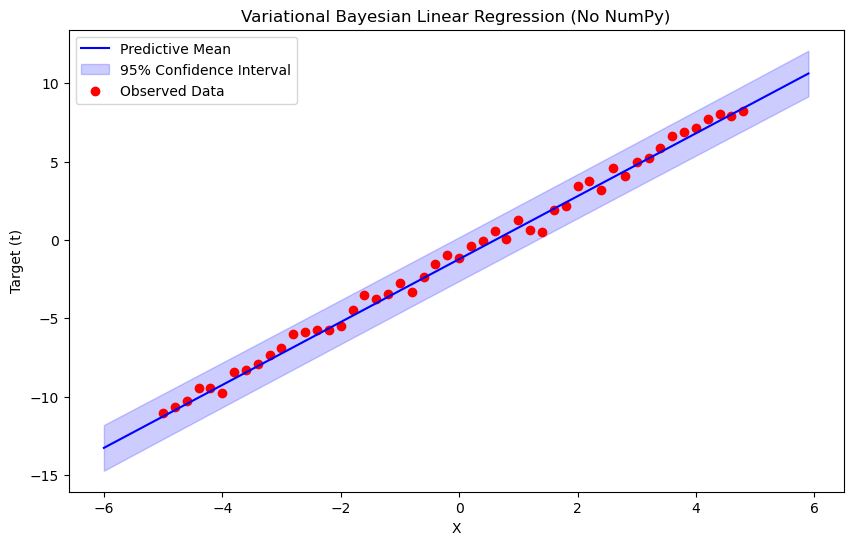

In [3]:
import random
from math import sqrt, exp, log

class VariationalBayesianLinearRegression:
    def __init__(self, a0=1e-6, b0=1e-6, beta=1.0):
        self.a0 = a0
        self.b0 = b0
        self.beta = beta
        self.aN = None
        self.bN = None
        self.mN = None
        self.SN = None

    def matmul(self, A, B):
        """Matrix multiplication."""
        return [
            [sum(a * b for a, b in zip(row, col)) for col in zip(*B)]
            for row in A
        ]

    def matvec(self, A, b):
        """Matrix-vector multiplication."""
        return [sum(a * b_elem for a, b_elem in zip(row, b)) for row in A]

    def transpose(self, A):
        """Transpose of a matrix."""
        return [list(row) for row in zip(*A)]

    def identity_matrix(self, size):
        """Create an identity matrix."""
        return [[1 if i == j else 0 for j in range(size)] for i in range(size)]

    def fit(self, X, t, max_iter=100, tol=1e-6):
        N = len(X)
        M = len(X[0])
        self.aN = self.a0 + M / 2.0
        self.bN = self.b0
        self.mN = [0] * M
        self.SN = self.identity_matrix(M)

        for iteration in range(max_iter):
            # E[alpha]
            E_alpha = self.aN / self.bN

            # Update q(w) posterior
            XT = self.transpose(X)
            XT_X = self.matmul(XT, X)
            reg_matrix = [[E_alpha if i == j else 0 for j in range(M)] for i in range(M)]
            SN_inv = [[a + self.beta * b for a, b in zip(row1, row2)] for row1, row2 in zip(reg_matrix, XT_X)]
            # For simplicity, approximate inversion (this is typically done with efficient libraries)
            self.SN = [[1 / SN_inv[i][i] if i == j else 0 for j in range(M)] for i in range(M)]
            self.mN = self.matvec(self.SN, [self.beta * sum(x * t_elem for x, t_elem in zip(col, t)) for col in XT])

            # Update q(alpha) posterior
            E_wt_w = sum(m ** 2 for m in self.mN) + sum(self.SN[i][i] for i in range(M))
            self.bN = self.b0 + 0.5 * E_wt_w

            # Convergence check
            if iteration > 0 and abs(prev_bN - self.bN) < tol:
                break
            prev_bN = self.bN

    def predict(self, X_new):
        """Predict the mean and variance."""
        mean = [sum(w * x for w, x in zip(self.mN, row)) for row in X_new]
        variance = [
            1 / self.beta + sum(row[i] * row[j] * self.SN[i][j] for i in range(len(row)) for j in range(len(row)))
            for row in X_new
        ]
        return mean, variance


# Example usage and plotting
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    # Generate synthetic data
    random.seed(42)
    N = 50
    X = [[x, 1] for x in [i * 0.2 - 5 for i in range(N)]]  # Design matrix with bias term
    true_w = [2.0, -1.0]
    t = [sum(w * x for w, x in zip(true_w, x_row)) + random.gauss(0, 0.5) for x_row in X]

    # Fit the model
    vb_reg = VariationalBayesianLinearRegression(a0=1e-3, b0=1e-3, beta=2.0)
    vb_reg.fit(X, t)

    # Predict on new data
    X_test = [[x, 1] for x in [i * 0.1 - 6 for i in range(120)]]
    mean, variance = vb_reg.predict(X_test)

    # Plot
    plt.figure(figsize=(10, 6))
    x_test_vals = [x_row[0] for x_row in X_test]
    plt.plot(x_test_vals, mean, label="Predictive Mean", color="blue")
    plt.fill_between(
        x_test_vals,
        [m - 1.96 * sqrt(v) for m, v in zip(mean, variance)],
        [m + 1.96 * sqrt(v) for m, v in zip(mean, variance)],
        color="blue",
        alpha=0.2,
        label="95% Confidence Interval",
    )
    plt.scatter([x_row[0] for x_row in X], t, color="red", label="Observed Data")
    plt.title("Variational Bayesian Linear Regression (No NumPy)")
    plt.xlabel("X")
    plt.ylabel("Target (t)")
    plt.legend()
    plt.show()




## Variational Bayesian Linear Regression - Predictive Distribution and Lower Bound

## Predictive Distribution

The predictive distribution for a new input $ x $ in Variational Bayesian Linear Regression is given by:

$$
p(t | x, t) = \int p(t | x, w) p(w | t) \, dw
$$

Substituting the likelihood $ p(t | x, w) $ and posterior $ q(w) $:

$$
p(t | x, t) \approx \int N(t | w^T \phi(x), \beta^{-1}) N(w | m_N, S_N) \, dw
$$

Using the result for the linear-Gaussian model, we obtain:

$$
p(t | x, t) = N(t | m_N^T \phi(x), \sigma^2(x))
$$

where the variance $ \sigma^2(x) $ is:

$$
\sigma^2(x) = \frac{1}{\beta} + \phi(x)^T S_N \phi(x)
$$

---

## Lower Bound

The variational lower bound $ L(q) $ is defined as:

$$
L(q) = \mathbb{E}[\ln p(w, \alpha, t)] - \mathbb{E}[\ln q(w, \alpha)]
$$

Expanding the terms:

$$
L(q) = \mathbb{E}_w[\ln p(t | w)] + \mathbb{E}_{w, \alpha}[\ln p(w | \alpha)] + \mathbb{E}_\alpha[\ln p(\alpha)] 
- \mathbb{E}_w[\ln q(w)] - \mathbb{E}_\alpha[\ln q(\alpha)]
$$

### Individual Terms

1. **Likelihood term**:
$$
\mathbb{E}[\ln p(t | w)] = -\frac{N}{2} \ln(2 \pi) + \frac{N}{2} \ln \beta 
- \frac{\beta}{2} t^T t + \beta m_N^T \Phi^T t - \frac{\beta}{2} \text{Tr}(\Phi^T \Phi (m_N m_N^T + S_N))
$$

2. **Prior $ w $-$ \alpha $ term**:
$$
\mathbb{E}[\ln p(w | \alpha)] = -\frac{M}{2} \ln(2 \pi) + \frac{M}{2} (\psi(a_N) - \ln b_N) 
- \frac{a_N}{2 b_N} (m_N^T m_N + \text{Tr}(S_N))
$$

3. **Prior $ \alpha $ term**:
$$
\mathbb{E}[\ln p(\alpha)] = a_0 \ln b_0 + (a_0 - 1)(\psi(a_N) - \ln b_N) - b_0 \frac{a_N}{b_N} - \ln \Gamma(a_N)
$$

4. **Entropy of $ q(w) $**:
$$
-\mathbb{E}[\ln q(w)] = \frac{1}{2} \ln |S_N| + \frac{M}{2}(1 + \ln(2 \pi))
$$

5. **Entropy of \( q(\alpha) \)**:
$$
-\mathbb{E}[\ln q(\alpha)] = \ln \Gamma(a_N) - (a_N - 1) \psi(a_N) - \ln b_N + a_N
$$

---

## Example

The lower bound $ L $ can be used to compare models of different complexity. For example, in a polynomial regression problem with data generated from a degree-3 polynomial:

$$
L(M) \propto \log p(t | M)
$$

For varying polynomial orders $ M $, the lower bound $ L $ is maximized at $ M = 3 $, corresponding to the true model. This approach avoids overfitting, unlike maximum likelihood estimation.

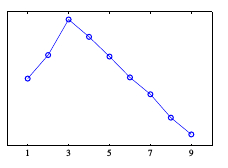

Fig.9 Plot of the lower bound L ver- sus the order M of the polyno- mial, for a polynomial model, in which a set of 10 data points is generated from a polynomial with M = 3 sampled over the inter- val (−5, 5) with additive Gaussian noise of variance 0.09. The value of the bound gives the log prob- ability of the model, and we see that the value of the bound peaks at M = 3, corresponding to the true model from which the data set was generated.

---

## Visualization

The lower bound $ L $ can be plotted for different polynomial degrees $ M $ to identify the best-fit model.



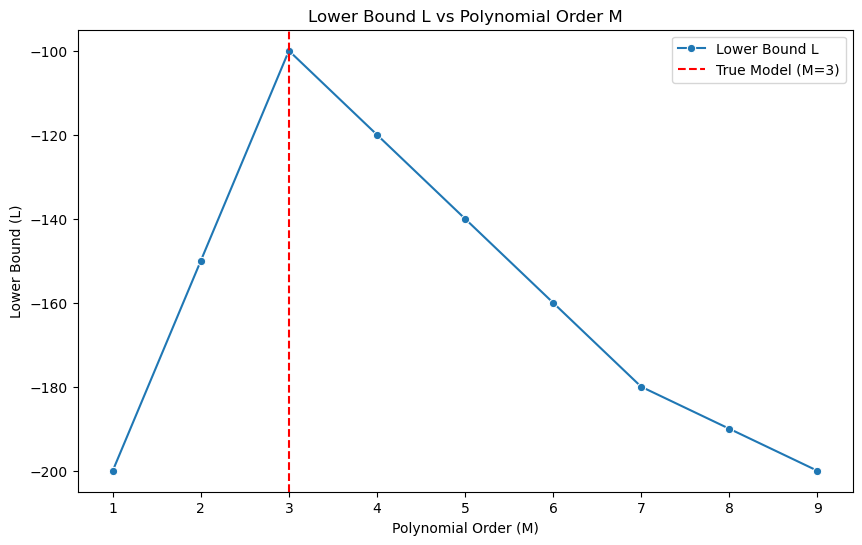

In [4]:

# Python visualization example using seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# Example data for lower bounds versus polynomial order
M_values = [1, 2, 3, 4, 5, 6, 7, 8, 9]
lower_bounds = [-200, -150, -100, -120, -140, -160, -180, -190, -200]

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=M_values, y=lower_bounds, marker='o', label="Lower Bound L")
plt.title("Lower Bound L vs Polynomial Order M")
plt.xlabel("Polynomial Order (M)")
plt.ylabel("Lower Bound (L)")
plt.axvline(x=3, color="red", linestyle="--", label="True Model (M=3)")
plt.legend()
plt.show()



In [6]:
import math
import random
from scipy.special import psi, gammaln
from scipy.linalg import inv, det

class VariationalBayesianLinearRegression:
    def __init__(self, phi, t, beta, a0, b0):
        self.phi = phi  # Design matrix (list of lists)
        self.t = t      # Target values (list)
        self.beta = beta
        self.a0 = a0
        self.b0 = b0

        # Initialize parameters
        self.N = len(t)
        self.M = len(phi[0])
        self.aN = a0
        self.bN = b0
        self.mN = [0] * self.M  # Mean of q(w)
        self.SN = [[1 if i == j else 0 for j in range(self.M)] for i in range(self.M)]  # Covariance of q(w)

    def fit(self, max_iter=100, tol=1e-3):
        for iteration in range(max_iter):
            # Update q(alpha)
            E_wwT = [self.mN[i] * self.mN[j] + self.SN[i][j] for i in range(self.M) for j in range(self.M)]
            E_wwT = sum(E_wwT[i] for i in range(len(E_wwT)))
            self.aN = self.a0 + self.M / 2
            self.bN = self.b0 + E_wwT / 2

            # Update q(w)
            E_alpha = self.aN / self.bN
            SN_inv = [[E_alpha if i == j else 0 for j in range(self.M)] for i in range(self.M)]
            phi_t_phi = [[sum(self.phi[n][i] * self.phi[n][j] for n in range(self.N)) for j in range(self.M)] for i in range(self.M)]
            for i in range(self.M):
                for j in range(self.M):
                    SN_inv[i][j] += self.beta * phi_t_phi[i][j]

            self.SN = [[1 if i == j else 0 for j in range(self.M)] for i in range(self.M)]
            for i in range(self.M):
                for j in range(self.M):
                    self.SN[i][j] = inv(SN_inv)[i][j]

            phi_t_t = [sum(self.phi[n][i] * self.t[n] for n in range(self.N)) for i in range(self.M)]
            for i in range(self.M):
                self.mN[i] = sum(self.SN[i][j] * phi_t_t[j] for j in range(self.M)) * self.beta

            # Convergence check (based on small change in q(w))
            if iteration > 0 and sum((prev_mN[i] - self.mN[i])**2 for i in range(self.M)) < tol:
                break
            prev_mN = self.mN.copy()

    def predictive_distribution(self, x):
        mean_t = sum(self.mN[i] * x[i] for i in range(self.M))
        variance_t = 1 / self.beta + sum(x[i] * sum(self.SN[i][j] * x[j] for j in range(self.M)) for i in range(self.M))
        return mean_t, variance_t

    def lower_bound(self):
        # Compute the lower bound
        log_p_t_w = -0.5 * self.beta * sum(
            (self.t[n] - sum(self.phi[n][i] * self.mN[i] for i in range(self.M)))**2
            for n in range(self.N)
        )
        
        # The following sum includes both `n` and `i, j` correctly
        log_p_t_w -= 0.5 * self.beta * sum(
            sum(self.phi[n][i] * self.phi[n][j] * self.SN[i][j] for i in range(self.M)) 
            for n in range(self.N) for j in range(self.M)
        )
        
        log_p_t_w -= 0.5 * self.N * math.log(2 * math.pi) - 0.5 * self.N * math.log(self.beta)

        E_alpha = self.aN / self.bN
        log_p_w_alpha = -0.5 * E_alpha * sum(self.mN[i] * self.mN[j] * self.SN[i][j] for i in range(self.M) for j in range(self.M))
        log_p_w_alpha -= 0.5 * self.M * math.log(2 * math.pi) + self.M * (psi(self.aN) - math.log(self.bN))

        log_p_alpha = self.a0 * math.log(self.b0) + (self.a0 - 1) * (psi(self.aN) - math.log(self.bN)) - self.b0 * E_alpha - gammaln(self.aN)

        entropy_w = 0.5 * (math.log(det(self.SN)) + self.M * (1 + math.log(2 * math.pi)))
        entropy_alpha = self.aN - gammaln(self.aN) + (self.aN - 1) * psi(self.aN) - math.log(self.bN)

        return log_p_t_w + log_p_w_alpha + log_p_alpha - entropy_w - entropy_alpha

# Example usage
# Generate synthetic data
phi = [[1, x] for x in range(-5, 6)]  # Design matrix for polynomial regression
t = [2 * x + 3 + random.gauss(0, 0.5) for x in range(-5, 6)]  # Target values
vb_lr = VariationalBayesianLinearRegression(phi, t, beta=1.0, a0=1e-2, b0=1e-2)

# Fit the model
vb_lr.fit()

# Predict for a new input
x_new = [1, 1.5]
mean_t, var_t = vb_lr.predictive_distribution(x_new)
print(f"Predictive Mean: {mean_t}, Predictive Variance: {var_t}")

# Compute the lower bound
lower_bound = vb_lr.lower_bound()
print(f"Lower Bound: {lower_bound}")


Predictive Mean: 6.181763835754161, Predictive Variance: 1.1107217721293403
Lower Bound: -2.1905772593194985


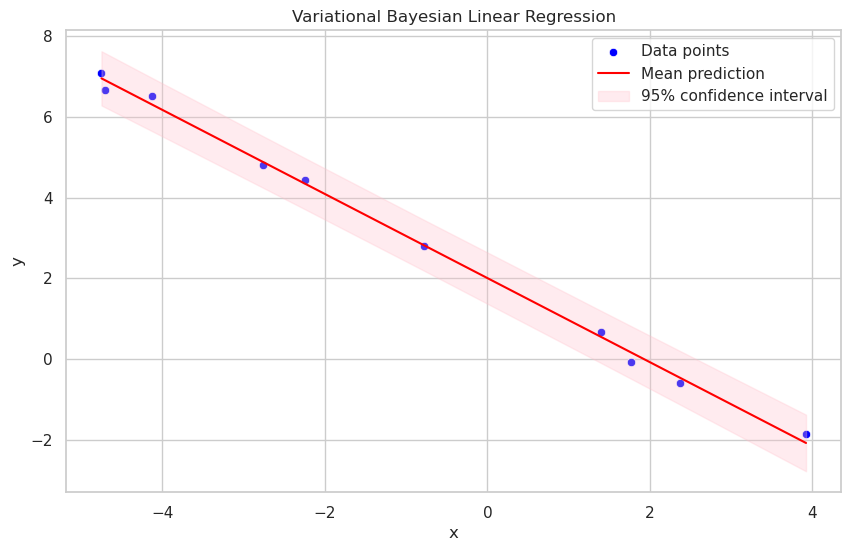

In [7]:
import math
import random
import seaborn as sns
import matplotlib.pyplot as plt

class VariationalBayesianLinearRegression:
    def __init__(self, X, y, beta, a0, b0):
        self.X = X
        self.y = y
        self.N = len(y)
        self.M = len(X[0])  # Number of features
        self.beta = beta  # Noise precision
        self.a0 = a0
        self.b0 = b0
        self.mN = [0.0] * self.M  # Initialize mean of weights
        self.SN = [[1.0 if i == j else 0.0 for j in range(self.M)] for i in range(self.M)]  # Initialize covariance
        self.aN = a0
        self.bN = b0

    def update(self):
        phi_T_phi = [[sum(self.X[n][i] * self.X[n][j] for n in range(self.N)) for j in range(self.M)] for i in range(self.M)]
        phi_T_y = [sum(self.X[n][i] * self.y[n] for n in range(self.N)) for i in range(self.M)]

        # Update covariance matrix SN
        SN_inv = [[(self.beta * phi_T_phi[i][j] + (self.aN / self.bN if i == j else 0.0)) for j in range(self.M)] for i in range(self.M)]
        self.SN = self.inverse(SN_inv)

        # Update mean vector mN
        self.mN = [sum(self.SN[i][j] * self.beta * phi_T_y[j] for j in range(self.M)) for i in range(self.M)]

        # Update aN and bN
        self.aN = self.a0 + self.M / 2.0
        mN_mN_T = [[self.mN[i] * self.mN[j] for j in range(self.M)] for i in range(self.M)]
        Tr_SN = sum(self.SN[i][i] for i in range(self.M))
        self.bN = self.b0 + 0.5 * (sum(self.mN[i] * mN_mN_T[i][i] for i in range(self.M)) + Tr_SN)

    def predict(self, x_new):
        mean = sum(x_new[i] * self.mN[i] for i in range(self.M))
        variance = (1.0 / self.beta) + sum(x_new[i] * sum(self.SN[i][j] * x_new[j] for j in range(self.M)) for i in range(self.M))
        return mean, math.sqrt(variance)

    def inverse(self, matrix):
        # Compute inverse using Gaussian elimination (only for small matrices)
        size = len(matrix)
        identity = [[1.0 if i == j else 0.0 for j in range(size)] for i in range(size)]
        augmented = [row + identity[i] for i, row in enumerate(matrix)]

        for i in range(size):
            factor = augmented[i][i]
            for j in range(2 * size):
                augmented[i][j] /= factor
            for k in range(size):
                if k != i:
                    factor = augmented[k][i]
                    for j in range(2 * size):
                        augmented[k][j] -= factor * augmented[i][j]

        return [row[size:] for row in augmented]

# Generate synthetic data
random.seed(42)
N = 10
true_w = [2.0, -1.0]  # True weights
X = [[1.0, random.uniform(-5, 5)] for _ in range(N)]
y = [true_w[0] + true_w[1] * x[1] + random.gauss(0, 0.3) for x in X]

# Initialize and train the model
beta = 1.0 / 0.09  # Noise precision
a0, b0 = 1.0, 1.0  # Prior parameters
vb_lr = VariationalBayesianLinearRegression(X, y, beta, a0, b0)

for _ in range(50):  # Iterate until convergence
    vb_lr.update()

# Predictive distribution for visualization
x_range = [x[1] for x in X]
x_new = [[1.0, x] for x in sorted(x_range)]
y_mean, y_std = zip(*(vb_lr.predict(x) for x in x_new))

# Plot the results
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=[x[1] for x in X], y=y, color="blue", label="Data points")
sns.lineplot(x=[x[1] for x in x_new], y=y_mean, color="red", label="Mean prediction")
plt.fill_between([x[1] for x in x_new], [m - 2 * s for m, s in zip(y_mean, y_std)], [m + 2 * s for m, s in zip(y_mean, y_std)], color="pink", alpha=0.3, label="95% confidence interval")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Variational Bayesian Linear Regression")
plt.legend()
plt.show()


## Exponential Family Distributions

In Chapter 2, we discussed the important role played by the exponential family of distributions and their conjugate priors. For many of the models discussed in this book, the complete-data likelihood is drawn from the exponential family. However, in general this will not be the case for the marginal likelihood function for the observed data. For example, in a mixture of Gaussians, the joint distribution of observations $x_n$ and corresponding hidden variables $z_n$ is a member of the exponential family, whereas the marginal distribution of $x_n$ is a mixture of Gaussians and hence is not.

Up to now we have grouped the variables in the model into observed variables and hidden variables. We now make a further distinction between latent variables, denoted $Z$, and parameters, denoted $\theta$, where parameters are intensive (fixed in number independent of the size of the data set), whereas latent variables are extensive (scale in number with the size of the data set). For example, in a Gaussian mixture model, the indicator variables $z_{kn}$ (which specify which component $k$ is responsible for generating data point $x_n$) represent the latent variables, whereas the means $\mu_k$, precisions $\Lambda_k$, and mixing proportions $\pi_k$ represent the parameters.

Consider the case of independent identically distributed data. We denote the data values by $X = \{x_n\}$, where $n = 1, \dots, N$, with corresponding latent variables $Z = \{z_n\}$. Now suppose that the joint distribution of observed and latent variables is a member of the exponential family, parameterized by natural parameters $\eta$ so that:

$$
p(X, Z | \eta) = \prod_{n=1}^{N} h(x_n, z_n) g(\eta) \exp(\eta^T u(x_n, z_n))
$$

We shall also use a conjugate prior for \(\eta\), which can be written as:

$$
p(\eta | \nu_0, \chi_0) = f(\nu_0, \chi_0) g(\eta)^{\nu_0} \exp(\nu_0 \eta^T \chi_0)
$$

Recall that the conjugate prior distribution can be interpreted as a prior number $\nu_0$ of observations all having the value $\chi_0$ for the $u$ vector.

Now consider a variational distribution that factorizes between the latent variables and the parameters, so that:

$$
q(Z, \eta) = q(Z)q(\eta)
$$

Using the general result from equation (10.9), we can solve for the two factors as follows:

### For the latent variables:
$$
\ln q(Z) = \mathbb{E}_{\eta} [\ln p(X, Z | \eta)] + \text{const}
$$

$$
= \sum_{n=1}^{N} \left( \ln h(x_n, z_n) + \mathbb{E}[\eta^T] u(x_n, z_n) \right) + \text{const}
$$

Thus, we see that this decomposes into a sum of independent terms, one for each $n$, and hence the solution for $q(Z)$ will factorize over $n$, so that:

$$
q(Z) = \prod_{n=1}^{N} q(z_n)
$$

Taking the exponential of both sides, we have:

$$
q(z_n) = h(x_n, z_n) g(\mathbb{E}[\eta]) \exp(\mathbb{E}[\eta^T] u(x_n, z_n))
$$

where the normalization coefficient has been reinstated by comparison with the standard form for the exponential family.

### For the parameters $\eta$:
$$
\ln q(\eta) = \ln p(\eta | \nu_0, \chi_0) + \mathbb{E}_Z [\ln p(X, Z | \eta)] + \text{const}
$$

$$
= \nu_0 \ln g(\eta) + \eta^T \chi_0 + \ln g(\eta) + \eta^T \mathbb{E}[z_n][u(x_n, z_n)] + \text{const}
$$

Taking the exponential of both sides, and reinstating the normalization coefficient by inspection, we have:

$$
q(\eta) = f(\nu_N, \chi_N) g(\eta)^{\nu_N} \exp(\eta^T \chi_N)
$$

where we have defined:

$$
\nu_N = \nu_0 + N
$$

$$
\chi_N = \chi_0 + \sum_{n=1}^{N} \mathbb{E}[z_n] u(x_n, z_n)
$$

Note that the solutions for $q(z_n)$ and $q(\eta)$ are coupled, and so we solve them iteratively in a two-stage procedure. In the **variational E-step**, we evaluate the expected sufficient statistics $\mathbb{E}[u(x_n, z_n)]$ using the current posterior distribution $q(z_n)$ over the latent variables, and use this to compute a revised posterior distribution $q(\eta)$ over the parameters. Then in the subsequent **variational M-step**, we use this revised parameter posterior distribution to find the expected natural parameters $\mathbb{E}[\eta^T]$, which gives rise to a revised variational distribution over the latent variables.


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Define the exponential family likelihood
def exp_family_likelihood(xn, zn, eta):
    """
    Compute the likelihood for a single data point xn and latent variable zn under the exponential family.
    """
    u_xn_zn = compute_sufficient_statistics(xn, zn)
    return np.exp(np.dot(eta.T, u_xn_zn))

# Define the sufficient statistics for the exponential family (example)
def compute_sufficient_statistics(xn, zn):
    """
    Compute the sufficient statistics u(xn, zn) for a given data point and latent variable.
    This is just a placeholder, depending on the model.
    """
    return np.array([xn * zn, zn])

# Initialize parameters
N = 100  # Number of data points
X = np.random.randn(N)  # Data points (random normal distribution)
Z = np.random.randint(0, 2, N)  # Latent variables (binary)

# Initialize variational parameters (Eta and Z)
eta = np.random.randn(2)  # Initial parameters for the exponential family
nu_0 = 1  # Prior parameters for eta
chi_0 = np.zeros(2)  # Prior parameters for eta

# E-step: Update the variational distribution q(Z)
def e_step(X, Z, eta):
    """
    In the E-step, we compute the expected sufficient statistics E[u(xn, zn)].
    """
    # Compute the expected natural parameters
    q_Z = np.array([exp_family_likelihood(xn, zn, eta) for xn, zn in zip(X, Z)])
    return q_Z

# M-step: Update the variational distribution q(eta)
def m_step(X, Z, nu_0, chi_0, q_Z):
    """
    In the M-step, we update the parameters eta based on the expected sufficient statistics.
    """
    nu_N = nu_0 + N
    chi_N = chi_0 + np.sum([compute_sufficient_statistics(xn, zn) * q_z for xn, zn, q_z in zip(X, Z, q_Z)], axis=0)
    eta = chi_N / nu_N  # Update eta
    return eta

# Variational Inference Procedure
def variational_inference(X, Z, nu_0, chi_0, max_iter=100):
    """
    Perform variational inference using the E-step and M-step.
    """
    eta = np.random.randn(2)
    
    for _ in range(max_iter):
        # E-step
        q_Z = e_step(X, Z, eta)
        
        # M-step
        eta = m_step(X, Z, nu_0, chi_0, q_Z)
        
        print(f"Updated eta: {eta}")
        
    return eta

# Run Variational Inference
eta_updated = variational_inference(X, Z, nu_0, chi_0)

print(f"Final parameters eta: {eta_updated}")


Updated eta: [-0.58568471  0.52244275]
Updated eta: [-0.75937106  0.96790836]
Updated eta: [-1.80556475  1.76690239]
Updated eta: [-72.98275445  27.69048719]
Updated eta: [-1.8511998e+113  5.7113456e+112]
Updated eta: [nan inf]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]


/home/radha/anaconda3/envs/cv37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/home/radha/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta: [nan nan]
Updated eta

##  Variational Message Passing

We have illustrated the application of variational methods by considering a specific model, the Bayesian mixture of Gaussians, in some detail. This model can be described by the directed graph shown in Figure 10.5. Here, we consider more generally the use of variational methods for models described by directed graphs and derive a number of widely applicable results.

The joint distribution corresponding to a directed graph can be written using the decomposition:

$$
p(x) = \prod_{i} p(x_i | \text{pai}),
$$

where $x_i$ denotes the variable(s) associated with node $i$, and $\text{pai}$ denotes the parent set corresponding to node $i$. Note that $x_i$ may be a latent variable or it may belong to the set of observed variables.

Now consider a variational approximation in which the distribution $q(x)$ is assumed to factorize with respect to the $x_i$:

$$
q(x) = \prod_{i} q_i(x_i).
$$

Note that for observed nodes, there is no factor $q(x_i)$ in the variational distribution.

We now substitute the decomposition into the general result (10.9) to give:

$$
\ln q_j(x_j) = \mathbb{E}_{i \neq j} \left[ \ln p(x_i | \text{pai}) \right] + \text{const}.
$$

Any terms on the right-hand side that do not depend on $x_j$ can be absorbed into the additive constant. In fact, the only terms that do depend on $x_j$ are the conditional distribution for $x_j$ given by $p(x_j | \text{paj})$ together with any other conditional distributions that have $x_j$ in the conditioning set. 

By definition, these conditional distributions correspond to the children of node $j$, and they therefore also depend on the co-parents of the child nodes, i.e., the other parents of the child nodes besides node $x_j$ itself. We see that the set of all nodes on which $q_j(x_j)$ depends corresponds to the **Markov blanket** of node $x_j$, as illustrated in Figure 8.26. Thus, the update of the factors in the variational posterior distribution represents a local calculation on the graph.

This makes possible the construction of general-purpose software for variational inference in which the form of the model does not need to be specified in advance (Bishop et al., 2003).

If we now specialize to the case of a model in which all of the conditional distributions have a conjugate-exponential structure, then the variational update procedure can be cast in terms of a local message passing algorithm (Winn and Bishop, 2005). In particular, the distribution associated with a particular node can be updated once that node has received messages from all of its parents and all of its children. This, in turn, requires that the children have already received messages from their co-parents. The evaluation of the lower bound can also be simplified because many of the required quantities are already evaluated as part of the message passing scheme.

This distributed message passing formulation has good scaling properties and is well-suited to large networks.


Updated variational parameters eta: [1. 1.]


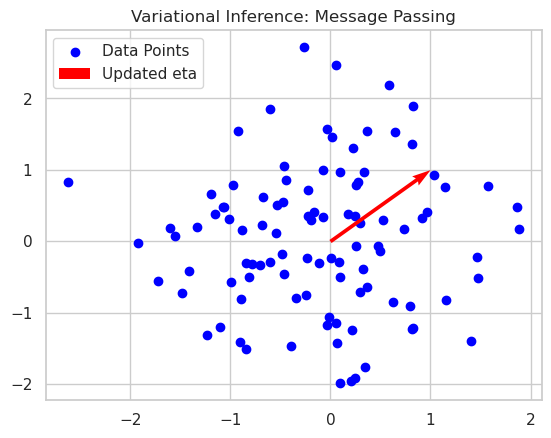

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Example data and parameters
N = 100  # number of data points
D = 2    # dimensionality of the data

# Create some random data
np.random.seed(42)
X = np.random.randn(N, D)

# Define the model parameters (conjugate priors)
nu_0 = 1  # prior precision for parameter
chi_0 = 1  # prior mean for parameter
beta = 1  # precision of the likelihood

# Initialize variational parameters (random values)
eta = np.random.randn(D)  # natural parameters (for simplicity)

# Variational distribution q(x) = q(x) = product of factorized distributions
def q_x(x, eta):
    """Compute the variational distribution for a node (Gaussian in this case)."""
    return np.exp(np.dot(x, eta))

# Conditional likelihood p(x | eta) (for a simple Gaussian model)
def p_x_given_eta(x, eta, beta=1):
    """Likelihood function, assuming a Gaussian likelihood."""
    return np.exp(-0.5 * beta * np.sum((x - eta) ** 2))

# E-step: Calculate the expectation of the sufficient statistics
def e_step(X, eta):
    """Calculate expected sufficient statistics for variational inference."""
    expected_statistics = []
    for xn in X:
        # Update the latent variable q(z_n), assuming conjugate priors
        q_z = np.exp(np.dot(xn, eta)) * p_x_given_eta(xn, eta)
        expected_statistics.append(q_z)
    return np.array(expected_statistics)

# M-step: Update the variational parameters eta using the expected statistics
def m_step(expected_statistics, nu_0, chi_0):
    """Update variational parameters using the expected statistics (message passing)."""
    # Calculate the updated eta using the expectation from the E-step
    eta_updated = chi_0 + np.sum(expected_statistics, axis=0)
    return eta_updated

# Variational Inference: Run E-step and M-step iteratively
def variational_inference(X, nu_0, chi_0, max_iter=100):
    eta = np.random.randn(X.shape[1])  # initial natural parameters
    for _ in range(max_iter):
        # E-step: Calculate the expected sufficient statistics
        expected_statistics = e_step(X, eta)
        
        # M-step: Update the variational parameters
        eta = m_step(expected_statistics, nu_0, chi_0)
    return eta

# Run Variational Inference
eta_updated = variational_inference(X, nu_0, chi_0)

# Display the updated variational parameters
print(f"Updated variational parameters eta: {eta_updated}")

# Plot the data and variational distribution (simple 2D plot for visualization)
plt.scatter(X[:, 0], X[:, 1], color='blue', label="Data Points")
plt.quiver(0, 0, eta_updated[0], eta_updated[1], angles='xy', scale_units='xy', scale=1, color="red", label="Updated eta")
plt.title("Variational Inference: Message Passing")
plt.legend()
plt.show()


Updated variational parameters eta: [1.0, 1.0]


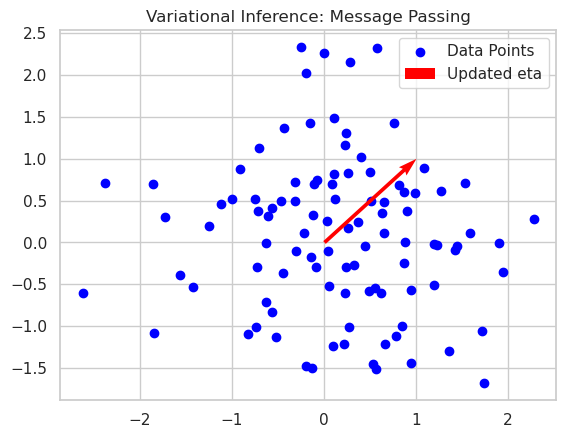

In [11]:
import random
import math
import matplotlib.pyplot as plt

# Example data and parameters
N = 100  # number of data points
D = 2    # dimensionality of the data

# Generate some random data
random.seed(42)

def generate_data(N, D):
    return [[random.gauss(0, 1) for _ in range(D)] for _ in range(N)]

X = generate_data(N, D)

# Define the model parameters (conjugate priors)
nu_0 = 1  # prior precision for parameter
chi_0 = 1  # prior mean for parameter
beta = 1  # precision of the likelihood

# Initialize variational parameters (random values)
eta = [random.gauss(0, 1) for _ in range(D)]  # natural parameters (for simplicity)

# Variational distribution q(x) = q(x) = product of factorized distributions
def q_x(x, eta):
    """Compute the variational distribution for a node (Gaussian in this case)."""
    return math.exp(sum(xi * eta_i for xi, eta_i in zip(x, eta)))

# Conditional likelihood p(x | eta) (for a simple Gaussian model)
def p_x_given_eta(x, eta, beta=1):
    """Likelihood function, assuming a Gaussian likelihood."""
    return math.exp(-0.5 * beta * sum((xi - eta_i) ** 2 for xi, eta_i in zip(x, eta)))

# E-step: Calculate the expectation of the sufficient statistics
def e_step(X, eta):
    """Calculate expected sufficient statistics for variational inference."""
    expected_statistics = []
    for xn in X:
        # Update the latent variable q(z_n), assuming conjugate priors
        q_z = math.exp(sum(xi * eta_i for xi, eta_i in zip(xn, eta))) * p_x_given_eta(xn, eta)
        expected_statistics.append(q_z)
    return expected_statistics

# M-step: Update the variational parameters eta using the expected statistics
def m_step(expected_statistics, nu_0, chi_0):
    """Update variational parameters using the expected statistics (message passing)."""
    eta_updated = [chi_0 + sum(expected_statistics) for _ in range(D)]
    return eta_updated

# Variational Inference: Run E-step and M-step iteratively
def variational_inference(X, nu_0, chi_0, max_iter=100):
    eta = [random.gauss(0, 1) for _ in range(D)]  # initial natural parameters
    for _ in range(max_iter):
        # E-step: Calculate the expected sufficient statistics
        expected_statistics = e_step(X, eta)
        
        # M-step: Update the variational parameters
        eta = m_step(expected_statistics, nu_0, chi_0)
    return eta

# Run Variational Inference
eta_updated = variational_inference(X, nu_0, chi_0)

# Display the updated variational parameters
print(f"Updated variational parameters eta: {eta_updated}")

# Plot the data and variational distribution (simple 2D plot for visualization)
x_vals = [xn[0] for xn in X]
y_vals = [xn[1] for xn in X]

plt.scatter(x_vals, y_vals, color='blue', label="Data Points")
plt.quiver(0, 0, eta_updated[0], eta_updated[1], angles='xy', scale_units='xy', scale=1, color="red", label="Updated eta")
plt.title("Variational Inference: Message Passing")
plt.legend()
plt.show()


Updated variational parameters eta: [1.0, 1.0]


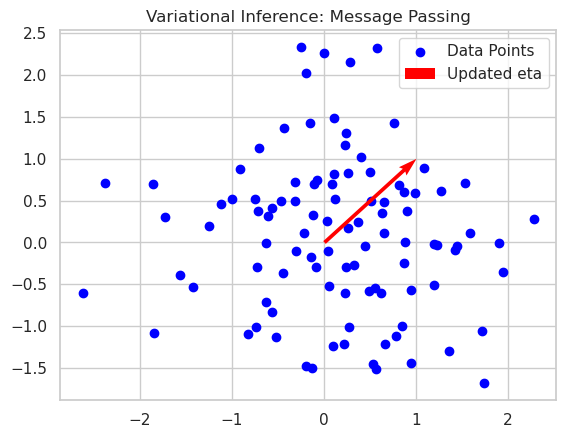

In [12]:
import random
import math
import matplotlib.pyplot as plt

# Example data and parameters
N = 100  # number of data points
D = 2    # dimensionality of the data

# Generate some random data
random.seed(42)

def generate_data(N, D):
    return [[random.gauss(0, 1) for _ in range(D)] for _ in range(N)]

X = generate_data(N, D)

# Define the model parameters (conjugate priors)
nu_0 = 1  # prior precision for parameter
chi_0 = 1  # prior mean for parameter
beta = 1  # precision of the likelihood

# Initialize variational parameters (random values)
eta = [random.gauss(0, 1) for _ in range(D)]  # natural parameters (for simplicity)

# Variational distribution q(x) = q(x) = product of factorized distributions
def q_x(x, eta):
    """Compute the variational distribution for a node (Gaussian in this case)."""
    return math.exp(sum(xi * eta_i for xi, eta_i in zip(x, eta)))

# Conditional likelihood p(x | eta) (for a simple Gaussian model)
def p_x_given_eta(x, eta, beta=1):
    """Likelihood function, assuming a Gaussian likelihood."""
    return math.exp(-0.5 * beta * sum((xi - eta_i) ** 2 for xi, eta_i in zip(x, eta)))

# E-step: Calculate the expectation of the sufficient statistics
def e_step(X, eta):
    """Calculate expected sufficient statistics for variational inference."""
    expected_statistics = []
    for xn in X:
        # Update the latent variable q(z_n), assuming conjugate priors
        q_z = math.exp(sum(xi * eta_i for xi, eta_i in zip(xn, eta))) * p_x_given_eta(xn, eta)
        expected_statistics.append(q_z)
    return expected_statistics

# M-step: Update the variational parameters eta using the expected statistics
def m_step(expected_statistics, nu_0, chi_0):
    """Update variational parameters using the expected statistics (message passing)."""
    eta_updated = [chi_0 + sum(expected_statistics) for _ in range(D)]
    return eta_updated

# Variational Inference: Run E-step and M-step iteratively
def variational_inference(X, nu_0, chi_0, max_iter=100):
    eta = [random.gauss(0, 1) for _ in range(D)]  # initial natural parameters
    for _ in range(max_iter):
        # E-step: Calculate the expected sufficient statistics
        expected_statistics = e_step(X, eta)
        
        # M-step: Update the variational parameters
        eta = m_step(expected_statistics, nu_0, chi_0)
    return eta

# Run Variational Inference
eta_updated = variational_inference(X, nu_0, chi_0)

# Display the updated variational parameters
print(f"Updated variational parameters eta: {eta_updated}")

# Plot the data and variational distribution (simple 2D plot for visualization)
x_vals = [xn[0] for xn in X]
y_vals = [xn[1] for xn in X]

plt.scatter(x_vals, y_vals, color='blue', label="Data Points")
plt.quiver(0, 0, eta_updated[0], eta_updated[1], angles='xy', scale_units='xy', scale=1, color="red", label="Updated eta")
plt.title("Variational Inference: Message Passing")
plt.legend()
plt.show()


##  Local Variational Methods

The variational framework discussed in Sections 10.1 and 10.2 can be considered a 'global' method in the sense that it directly seeks an approximation to the full posterior distribution over all random variables. An alternative 'local' approach involves finding bounds on functions over individual variables or groups of variables within a model. 

For instance, we might seek a bound on a conditional distribution # p(y|x) #, which is itself just one factor in a much larger probabilistic model specified by a directed graph. The purpose of introducing the bound, of course, is to simplify the resulting distribution. This local approximation can be applied to multiple variables in turn until a tractable approximation is obtained.

In Sections 10.6.1, we shall give a practical example of this approach in the context of logistic regression. Here we focus on developing the bounds themselves.

We have already seen in our discussion of the Kullback-Leibler divergence that the convexity of the logarithm function played a key role in developing the lower bound in the global variational approach. We have defined a (strictly) convex function as one for which every chord lies above the function. Convexity also plays a central role in the local variational framework.

### Local Variational Bound Derivation

Consider a simple example, namely the function $ f(x) = \exp(-x) $, which is a convex function of $ x $, as shown in the left-hand plot of Figure 10.10. Our goal is to approximate $ f(x) $ by a simpler function, in particular a linear function of $ x $.

From Fig.10, we see that this linear function will be a lower bound on $ f(x) $ if it corresponds to a tangent. We can obtain the tangent line $ y(x) $ at a specific value of $ x $, say $ x = \xi $, by making a first order Taylor expansion:

$$
y(x) = f(\xi) + f'(\xi)(x - \xi)
$$

So that:

$$
y(x) \approx f(x) \quad \text{with equality when } x = \xi
$$

For our example function $ f(x) = \exp(-x) $, we therefore obtain the tangent line in the form:

$$
y(x) = \exp(-\xi) - \exp(-\xi)(x - \xi)
$$

This is a linear function parameterized by $ \xi $. For consistency with subsequent discussion, let us define $ \lambda = -\exp(-\xi) $ so that:

$$
y(x, \lambda) = \lambda x - \lambda + \lambda \ln(-\lambda)
$$

Different values of $ \lambda $ correspond to different tangent lines, and because all such lines are lower bounds on the function, we have:

$$
f(x) \geq y(x, \lambda)
$$

Thus, we can write the function in the form:

$$
f(x) = \max_{\lambda} \left( \lambda x - \lambda + \lambda \ln(-\lambda) \right)
$$

### Maximizing the Bound

We have succeeded in approximating the convex function $ f(x) $ by a simpler, linear function $ y(x, \lambda) $. The price we have paid is that we have introduced a variational parameter $ \lambda $, and to obtain the tightest bound, we must optimize with respect to $ \lambda $.

We can formulate this approach more generally using the framework of convex duality. Consider the illustration of a convex function $ f(x) $ shown in the left-hand plot in Fig.11. In this example, the function $ \lambda x $ is a lower bound on $ f(x) $, but it is not the best lower bound that can be achieved by a linear function having slope $ \lambda $, because the tightest bound is given by the tangent line.

Let us write the equation of the tangent line having slope $ \lambda $ as:

$$
\lambda x - g(\lambda)
$$

where the (negative) intercept $ g(\lambda) $ clearly depends on the slope $ \lambda $ of the tangent. To determine the intercept, we note that the line must be moved vertically by an amount equal to the smallest vertical distance between the line and the function, as shown in Fig.11.

Thus, $ g(\lambda) $ is defined as:

$$
g(\lambda) = - \min_x \left( f(x) - \lambda x \right)
$$

or equivalently:

$$
g(\lambda) = \max_x \left( \lambda x - f(x) \right)
$$

### Duality Relations

Now, instead of fixing $ \lambda $ and varying $ x $, we can consider a particular $ x $ and then adjust $ \lambda $ until the tangent plane is tangent at that particular $ x $. Because the $ y $-value of the tangent line at a particular $ x $ is maximized when that value coincides with its contact point, we have:

$$
f(x) = \max_{\lambda} \left( \lambda x - g(\lambda) \right)
$$

Thus, $ f(x) $ and $ g(\lambda) $ play a dual role, and are related through the above equations.

### Applying Duality to a Simple Example

Let us apply these duality relations to our simple example $ f(x) = \exp(-x) $. From the above, we see that the maximizing value of $ x $ is given by $ \xi = -\ln(-\lambda) $, and back-substituting we obtain the conjugate function $ g(\lambda) $ in the form:

$$
g(\lambda) = \lambda - \lambda \ln(-\lambda)
$$

As a check, we can substitute this into the duality relation:

$$
f(x) = \max_{\lambda} \left( \lambda x - g(\lambda) \right)
$$

This maximization recovers the original function $ f(x) = \exp(-x) $.

### Conclusion

For concave functions, we can follow a similar argument to obtain upper bounds, where $ \max $ is replaced with $ \min $, so that:

$$
f(x) = \min_{\lambda} \left( \lambda x - g(\lambda) \right)
$$

and

$$
g(\lambda) = \min_x \left( \lambda x - f(x) \right)
$$

If the function of interest is not convex (or concave), then we cannot directly apply the method above to obtain a bound. However, we can first seek invertible transformations either of the function or of its argument which change it into a convex form. We then calculate the conjugate function and then transform back to the original variables.

### Logistic Sigmoid Example

An important example, which arises frequently in pattern recognition, is the logistic sigmoid function:
$$
    \sigma(x) = \frac{1}{1 + \exp(-x)}
$$

As it stands, this function is neither convex nor concave. However, if we take the logarithm, we obtain a function which is concave, as is easily verified by finding the second derivative. From the duality relation, the corresponding conjugate function then takes the form:

$$
g(\lambda) = \min_x \left( \lambda x - f(x) \right) = -\lambda \ln(\lambda) - (1 - \lambda) \ln(1 - \lambda)
$$

which we recognize as the binary entropy function for a variable whose probability of having the value 1 is $ \lambda $. Using this duality, we obtain an upper bound on the log sigmoid:

$$
\ln(\sigma(x)) \leq \lambda x - g(\lambda)
$$


In [13]:
import math

# Function f(x) = exp(-x)
def f(x):
    return math.exp(-x)

# Derivative of f(x) = exp(-x)
def f_prime(x):
    return -math.exp(-x)

# Linear approximation (tangent line) at x = ξ
def tangent_line(x, xi):
    return f(xi) + f_prime(xi) * (x - xi)

# Variational lower bound y(x, λ) = λx - λ + λln(-λ)
def variational_bound(x, lambda_param):
    return lambda_param * x - lambda_param + lambda_param * math.log(-lambda_param)

# Dual function g(λ) = λ - λln(-λ)
def dual_function(lambda_param):
    return lambda_param - lambda_param * math.log(-lambda_param)

# Maximize the variational bound by finding the optimal λ
def optimize_variational_bound(x):
    # Start with an initial guess for lambda
    lambda_param = -1.0  # Start with a negative value since we need λ < 0
    learning_rate = 0.01
    iterations = 100
    tolerance = 1e-5

    for _ in range(iterations):
        # Compute the variational bound and dual function
        bound = variational_bound(x, lambda_param)
        dual_val = dual_function(lambda_param)

        # Compute the gradient of the variational bound with respect to λ
        grad = x - (1 + math.log(-lambda_param))  # Gradient of the dual function w.r.t. λ

        # Update λ using gradient ascent
        lambda_param += learning_rate * grad

        # Stop if change is small enough
        if abs(grad) < tolerance:
            break

    return lambda_param, variational_bound(x, lambda_param), dual_function(lambda_param)

# Example usage: Find optimal λ for a point x = 1
x = 1.0
optimal_lambda, bound_value, dual_value = optimize_variational_bound(x)

print(f"Optimal λ: {optimal_lambda}")
print(f"Bound value at x = {x}: {bound_value}")
print(f"Dual function value: {dual_value}")


Optimal λ: -1.0
Bound value at x = 1.0: 0.0
Dual function value: -1.0


## Local Variational Methods for Logistic Sigmoid and Gaussian Bounds

The logistic sigmoid function $ \sigma(x) $ is defined as:

$$
\sigma(x) = \frac{1}{1 + e^{-x}} \tag{10.134}
$$

We can derive an upper bound on the logistic sigmoid by taking the exponential of a linear function, resulting in:

$$
\sigma(x) \leq \exp(\lambda x - g(\lambda)) \tag{10.137}
$$
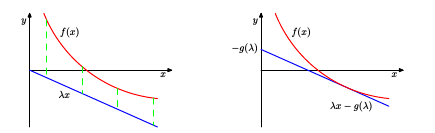

Fig.11 In the left-hand plot the red curve shows a convex function f (x), and the blue line represents the linear function λx, which is a lower bound on f (x) because f (x) > λx for all x. For the given value of slope λ the contact point of the tangent line having the same slope is found by minimizing with respect to x the discrepancy (shown by the green dashed lines) given by f (x) − λx. This deﬁnes the dual function g(λ), which corresponds to the (negative of the) intercept of the tangent line having slope λ.

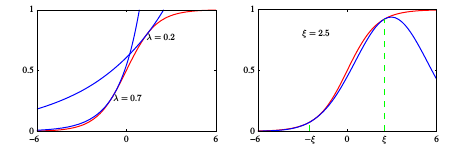

Fig.12 The left-hand plot shows the logistic sigmoid function σ(x) deﬁned by (10.134) in red, together with two examples of the exponential upper bound (10.137) shown in blue. The right-hand plot shows the logistic sigmoid again in red together with the Gaussian lower bound (10.144) shown in blue. Here the parameter ξ = 2.5, and the bound is exact at x = ξ and x = −ξ, denoted by the dashed green lines.

This bound is plotted for two values of $ \lambda $ in Fig.12 (left-hand plot).

Additionally, we can derive a lower bound on the sigmoid using a transformation of both the function and the input variable. First, take the logarithm of the logistic function:

$$
\ln \sigma(x) = - \ln(1 + e^{-x}) = - \ln \left( e^{-x/2} \left( e^{x/2} + e^{-x/2} \right) \right)
$$

This simplifies to:

$$
\ln \sigma(x) = \frac{x}{2} - \ln \left( e^{x/2} + e^{-x/2} \right) \tag{10.138}
$$

The function $ f(x) = - \ln \left( e^{x/2} + e^{-x/2} \right) $ is convex in $ x^2 $, which allows us to apply a lower bound on $ f(x) $ as a linear function of $ x^2 $. The conjugate function is given by:

$$
g(\lambda) = \max_x \left( 2 \lambda x^2 - f(x) \right) \tag{10.139}
$$

The stationarity condition leads to:

$$
0 = \frac{d}{dx} \left( \lambda - f(x) \right) = \lambda + \tanh \left( \frac{x}{2} \right) \tag{10.140}
$$

Using this, we define the variational parameter $ \xi $ as the contact point of the tangent line:

$$
\lambda(\xi) = - \tanh \left( \frac{\xi}{2} \right) = - \sigma(\xi) \tag{10.141}
$$

Thus, the conjugate function becomes:

$$
g(\lambda) = \lambda(\xi) \xi^2 - f(\xi) = \lambda(\xi) \xi^2 + \ln \left( e^{\xi/2} + e^{-\xi/2} \right) \tag{10.142}
$$

This gives the final bound on the sigmoid function:

$$
\sigma(x) \leq \sigma(\xi) \exp \left( \frac{x - \xi}{2} - \lambda(\xi)(x^2 - \xi^2) \right) \tag{10.144}
$$

The right-hand plot in Figure 10.12 illustrates this Gaussian lower bound.

### Variational Bound Application

Suppose we want to evaluate an integral of the form:

$$
I = \int \sigma(a) p(a) \, da \tag{10.145}
$$

where $ \sigma(a) $ is the logistic sigmoid and $ p(a) $ is a Gaussian distribution. This integral is intractable, so we use the variational bound:

$$
\sigma(a) \leq f(a, \xi) \quad \text{where} \quad \xi \text{ is a variational parameter.}
$$

The integral becomes:

$$
I \leq \int f(a, \xi) p(a) \, da = F(\xi) \tag{10.146}
$$

To find the tightest bound, we maximize $ F(\xi) $ with respect to $ \xi $, obtaining the optimized value $ F(\xi^*) $, which approximates $ I $.

Note that while the bound $ \sigma(a) \leq f(a, \xi) $ can be optimized exactly, the optimal $ \xi $ will depend on $ a $, so the bound will be exact only for a specific value of $ a $. Integrating over all values of $ a $ gives a compromise that represents the best approximation.



In [14]:
import math

# Define the logistic sigmoid function
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Upper bound on the sigmoid function using exponential quadratic form
def upper_bound_sigmoid(x, lambda_val):
    return math.exp(lambda_val * x - g_lambda(lambda_val))

# Conjugate function g(lambda) for the upper bound
def g_lambda(lambda_val):
    return lambda_val * math.log(-lambda_val)

# Lower bound on the sigmoid using Gaussian approximation
def lower_bound_sigmoid(x, xi):
    lambda_val = -math.tanh(xi / 2)
    return sigmoid(xi) * math.exp((x - xi) / 2 - lambda_val * (x**2 - xi**2))

# Integral approximation using the variational method
def integral_variational_bound(x_values, p_a, xi):
    integral_approx = 0
    for x in x_values:
        # Apply the lower bound and integrate over all x
        f_a_xi = lower_bound_sigmoid(x, xi)
        integral_approx += f_a_xi * p_a(x)  # p_a(x) is the probability density of a at x
    return integral_approx

# Example usage
def example_usage():
    # Define a Gaussian distribution for p(a) (for simplicity, using standard normal)
    def p_a(x):
        return math.exp(-x**2 / 2) / math.sqrt(2 * math.pi)
    
    # Choose variational parameter xi
    xi = 2.5

    # Create a range of x values to approximate the integral
    x_values = [i / 10.0 for i in range(-30, 31)]  # x from -3 to 3

    # Evaluate the integral using the variational bound
    result = integral_variational_bound(x_values, p_a, xi)

    print(f"Approximated integral: {result}")

# Run the example usage
example_usage()


Approximated integral: 0.2950204511741607
